In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


2021-10-27 11:49:35.695938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 11:49:35.702035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 11:49:35.702380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# params for dataset loading
# IMPT: remember to change ds_order (dataset order) accordingly
store_path = './datasets/sa/'
dataset_paths = ['4g_1.csv', '4g_2.csv', '5G_TEST_1.csv', '5G_2.csv', 'bt_2.csv']
ds_order = ['4G', '4G', 'WIFI', 'WIFI', 'BLUETOOTH']
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in ds_order])))}

# do consistency checks
# stop execution if dataset_paths and ds_order are not of equal length
assert (len(dataset_paths) == len(ds_order)), 'Length of dataset_paths and ds_order are mismatched.'
# check if all ds_order tags are in record_tags
# assert all(item in list(record_tags.keys()) for item in ds_order), 'Not all ds_order tags exist in record_tags'

In [3]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for path in dataset_paths:
    path = store_path + path
    print(f'loading {path}...', end=' ')
    
    # load dataset details
    df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
    df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')
    
    specs.append(df_spec)

    # load data
    df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
    df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
    df['I'] = df['I'].astype('float')
    
    print(f'loaded')
    
    datasets.append(df)
    
print('done.')

loading ./datasets/sa/4g_1.csv... loaded
loading ./datasets/sa/4g_2.csv... loaded
loading ./datasets/sa/5G_TEST_1.csv... loaded
loading ./datasets/sa/5G_2.csv... loaded
loading ./datasets/sa/bt_2.csv... loaded
done.


In [4]:
# split dataset(s) into records, extract test dataset
train = []

# number of test records to extract
ntest = 100

print(f'Type\t\tTotal Records\tSamples/Record')
for i in range(len(datasets)):
    nrecords = specs[i].loc['NumberRecords']['info']
    nsamples = specs[i].loc['NumberSamples']['info']

    # sanity check
    print(f'{ds_order[i]:<13}\t{nrecords:<7}\t\t{nsamples:<7}')

    # loop through dataset to split 
    for j in range(nrecords):
        # extract sample length worth of samples for each record, then transpose for easier access later
        record = datasets[i].iloc[(nsamples * j):(nsamples * (j+1))].values.T
    
        # add processed record to list
        train.append([ds_order[i], signal_tags[ds_order[i]], record])

# convert list into dataframes for later use, randomise, extract test records
df_train = pd.DataFrame(train, columns=['signal_type', 'tag', 'record']).sample(frac=1, random_state=42)
df_test = df_train.groupby('signal_type', group_keys=False).apply(lambda df: df.head(ntest)).sample(frac=1, random_state=42)
df_train = df_train.drop(df_test.index)

# print dataset statistics
print(f'\n{"Stats":^13}')
print(f'Dataset\tLength')
print(f'Train\t{df_train.shape[0]:<5}')
print(f'Test\t{df_test.shape[0]:<5}')

Type		Total Records	Samples/Record
4G           	3202   		1014   
4G           	3550   		1014   
WIFI         	2699   		1014   
WIFI         	1200   		1014   
BLUETOOTH    	23885  		1014   

    Stats    
Dataset	Length
Train	34236
Test	300  


In [5]:
df_test.head(3)

,signal_type,tag,record
9238,WIFI,2,"[[4.656e-05, 4.959e-05, -0.00054823, -0.000353..."
8230,WIFI,2,"[[0.00408652, -0.00055405, -0.0021896, 0.02937..."
19906,BLUETOOTH,1,"[[0.01437186, -0.0035353, -0.01005741, 0.01670..."


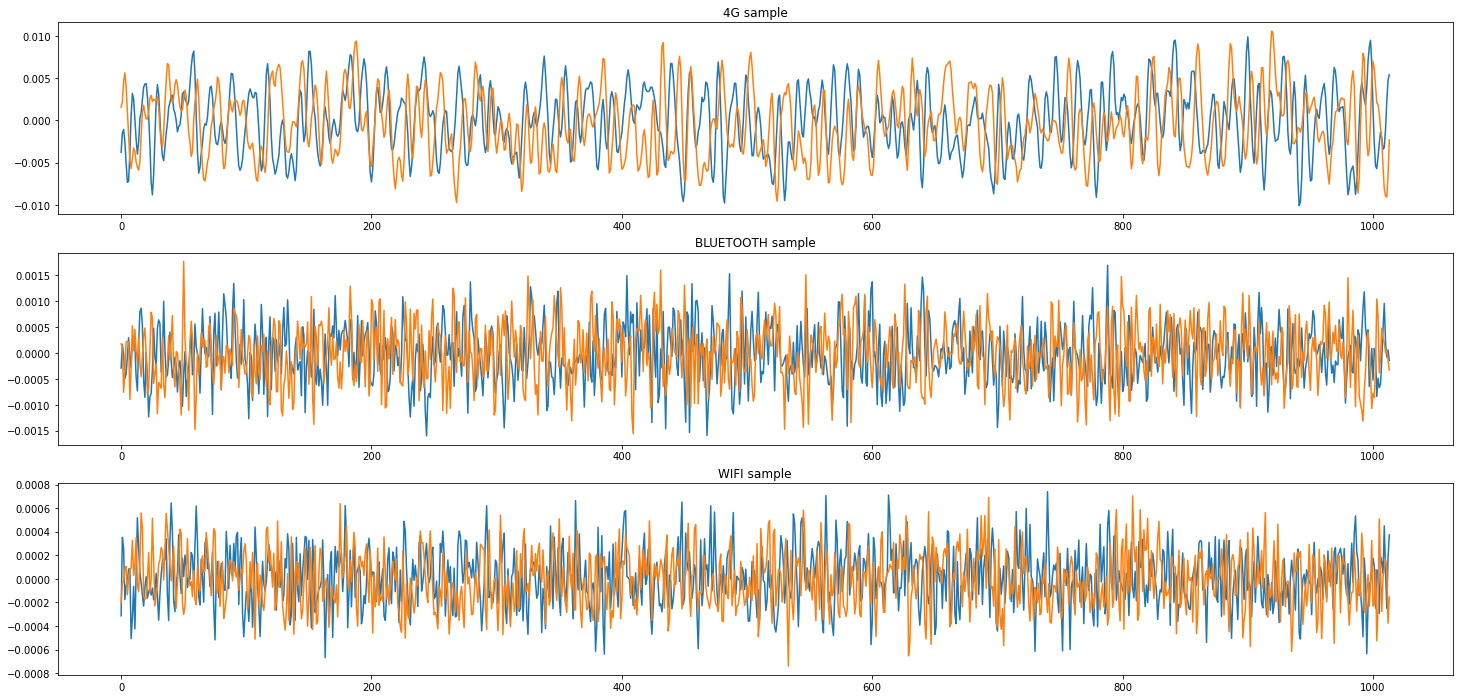

In [6]:
# plot some sample signals
fig1 = plt.figure(1, figsize=(25, 12))

for i, key in enumerate(list(signal_tags.keys())):
    ip, qd = df_train[df_train['signal_type'] == key]['record'].sample().iloc[0]
    
    ax = fig1.add_subplot(3, 1, i+1)

    ax.plot(ip)
    ax.plot(qd)
    
    ax.set_title(f'{key} sample')
    
plt.show()

In [7]:
# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

In [8]:
# extract train and test data
X_train = np.concatenate(df_train['record'].values).reshape((df_train.shape[0], 2, 1014, 1))
y_train = one_hot(df_train['tag'].values, len(signal_tags))

X_test = np.concatenate(df_test['record'].values).reshape((df_test.shape[0], 2, 1014, 1))
y_test = one_hot(df_test['tag'].values, len(signal_tags))

In [9]:
# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Dense, Input, Flatten

In [10]:
# functions for model segments
def res_unit(x, dim, n):
    '''
    function that creates a residual unit for each residual stack.

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of layer
    n: number of units to create
    '''

    for _ in range(n):
        u = Conv2D(dim, 2, activation='relu', padding='same')(x)
        u = Conv2D(dim, 2, activation='linear', padding='same')(u)

        # skip-con
        x = concatenate([u, x])

    return x

def res_stack(x, dim):
    '''
    function that creates a residual stack for the model

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of stack
    '''

    s = Conv2D(dim, 1, activation='linear', padding='same')(x)
    s = res_unit(s, dim, 2)
    s = MaxPooling2D(2, padding='same')(s)

    return s

In [11]:
# function to create main model
def create_model(in_dim, out_dim):
    '''
    function to construct the actual resnet model.

    INPUT PARAMETERS
    in_dim: dimensions of input
    out_dim: size of output
    '''

    input_layer = Input(in_dim)
    
    # res stacks
    x = res_stack(input_layer, 512)
    x = res_stack(x, 256)
    x = res_stack(x, 128)
    x = res_stack(x, 64)
    x = res_stack(x, 32)
    x = res_stack(x, 16)

    # fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='selu')(x)
    x = Dense(128, activation='selu')(x)

    output_layer = Dense(out_dim, activation='softmax')(x)

    # turn layers into model
    model = Model(inputs=input_layer, outputs=output_layer, name='resnet_rf_classification_model')

    return model

2021-10-27 11:49:54.710120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-27 11:49:54.710520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 11:49:54.710830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 11:49:54.711068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

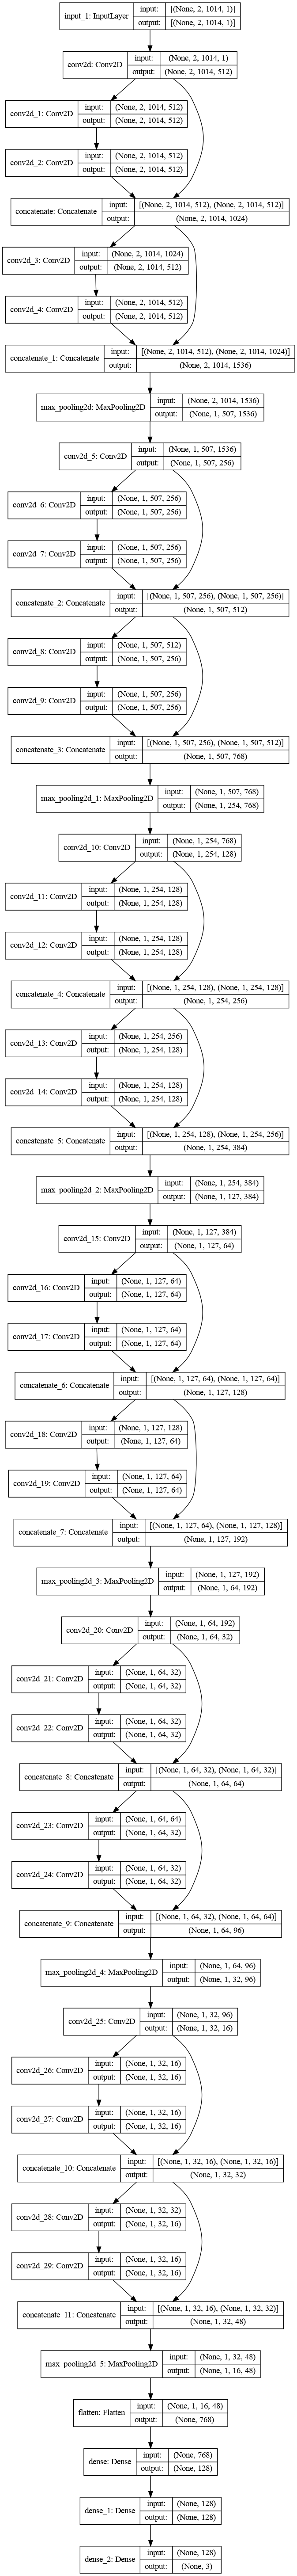

In [12]:
model = create_model((2, 1014, 1), len(signal_tags))

tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
# train model
# import metrics
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#early stopping
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=50, callbacks=[callback], validation_split=0.2)

2021-10-27 11:49:55.664679: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-10-27 11:49:57.088276: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-10-27 11:49:57.696258: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-27 11:49:57.696605: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-27 11:49:57.696621: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-27 11:49:57.697012: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-27 11:49:57.697066: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-10-27 11:50:03.847029: I tensorflow/stream_executor/cuda/c

547/548 [============================>.] - ETA: 0s - loss: 0.6333 - accuracy: 0.7701

2021-10-27 11:53:13.079679: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-27 11:53:13.079720: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


548/548 [==============================] - 217s 377ms/step - loss: 0.6343 - accuracy: 0.7697 - val_loss: 0.7477 - val_accuracy: 0.6968
Epoch 2/50
548/548 [==============================] - 195s 356ms/step - loss: 0.3210 - accuracy: 0.8874 - val_loss: 0.1200 - val_accuracy: 0.9689
Epoch 3/50
548/548 [==============================] - 196s 358ms/step - loss: 0.2720 - accuracy: 0.9234 - val_loss: 0.2993 - val_accuracy: 0.9004
Epoch 4/50
548/548 [==============================] - 195s 356ms/step - loss: 0.2521 - accuracy: 0.9191 - val_loss: 0.1721 - val_accuracy: 0.9382
Epoch 5/50
548/548 [==============================] - 200s 365ms/step - loss: 0.0904 - accuracy: 0.9746 - val_loss: 0.0489 - val_accuracy: 0.9885
Epoch 6/50
548/548 [==============================] - 201s 366ms/step - loss: 0.0487 - accuracy: 0.9875 - val_loss: 0.0248 - val_accuracy: 0.9927
Epoch 7/50
548/548 [==============================] - 203s 371ms/step - loss: 0.1106 - accuracy: 0.9717 - val_loss: 0.0342 - val_accura

In [14]:
# evaluate model performance on standard dataset
results = model.evaluate(X_test, y_test)

print(f'loss: {results[0]:.3f} | accuracy: {results[1]:.3f}')

10/10 [==============================] - 6s 295ms/step - loss: 0.0085 - accuracy: 0.9967
loss: 0.009 | accuracy: 0.997


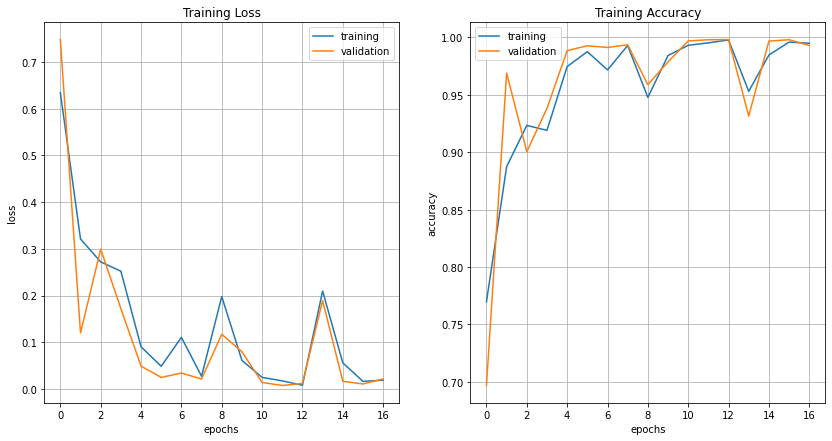

In [15]:
# plot out loss and accuracy graphs
train_hist = history.history

fig = plt.figure(1, figsize=(14, 7))

# loss graph
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_hist['loss'], label='training')
ax1.plot(train_hist['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(b=True)

# accuracy graph
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_hist['accuracy'], label='training')
ax2.plot(train_hist['val_accuracy'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(b=True)

plt.show()

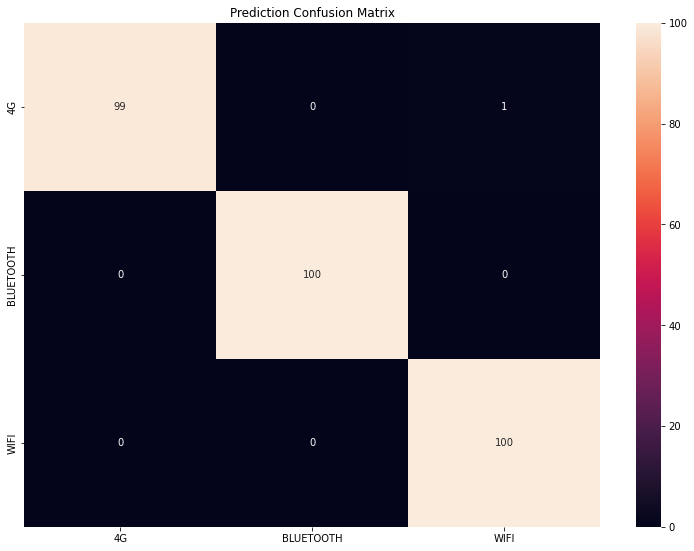

In [16]:
# plot confusion matrices
cm_pred = model.predict(X_test)

# process results
temp = []
for row in cm_pred:
    temp.append(np.argmax(row))  
cm_pred = np.array(temp)

cm_truth = df_test['tag'].values

# generate matrix
tags = list(signal_tags.keys())
df_cm = pd.DataFrame(tf.math.confusion_matrix(cm_truth, cm_pred).numpy(), index=tags, columns=tags)

# plot matrix
fig = plt.figure(2, figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
sns.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title('Prediction Confusion Matrix')

plt.show()

In [17]:
# save model
model.save('./saved_models/SA_resnet')

2021-10-27 12:46:26.237908: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/SA_resnet/assets
